In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import idx2numpy
import imageio
from idx_tools import Idx

%matplotlib inline

In [ ]:
## This is the part for extracting digits from laser images

In [2]:
# Renaming the files 
import os
os.getcwd()
collection = "./Chip_photos"
for i, filename in enumerate(os.listdir(collection)):
    os.rename("./Chip_photos/" + filename, "./Chip_photos/" + "Image_"+ str(i) + ".jpg")

In [ ]:
import cv2  # Computer vision library
import imageio
import os
import numpy as np

# Read the color image

for image in os.listdir('./Chip_photos/'):
    image = cv2.imread(os.path.join('./Chip_photos/', image))
    
    #new_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
    inverted_binary = ~binary
    contours, hierarchy = cv2.findContours(inverted_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    with_contours = cv2.drawContours(gray, contours, 3,(0,0,255),1)
    
    
    path='./char_7'
    n = len(os.listdir('./char_7')) + 1
    n_roi = np.shape(contours)[0]
   
    for c in contours:
##for c in range(n_roi):
        x,y,w,h = cv2.boundingRect(c)
        if (cv2.contourArea(c)) > 50:
        #cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 1)
            cv2.rectangle(image,(x,y), (x+w,y+h), (255,0,0), 1)
            ROI = with_contours[y:y+h, x:x+w]
        #cv2.imwrite('./char_3/ROI_{}.jpg'.format(ROI_number), ROI)
        #imageio.imwrite('{}/char{}.jpg'.format(ROI_number), ROI)
            imageio.imwrite('{}/char{}.jpg'.format(path, n), ROI)
        #ROI_number += 1
            n += 1
    
    

In [ ]:
## This is the part for clustering and converting images into idx format for NN 

In [6]:
#Convertinf some of the images to gray scale to be consistant
import cv2
import imageio
import os
import numpy as np
import glob


for image in os.listdir('./color_characters/'):
    image = cv2.imread(os.path.join('./color_characters/', image))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    path='./characters_gray'
    n = len(os.listdir('./characters_gray')) + 1
    imageio.imwrite('{}/char{}.jpg.jpg'.format(path, n), gray)


In [7]:
# Renaming the files after converting the rest to thr gray scale
import os
os.getcwd()
collection = "./all_characters"
for i, filename in enumerate(os.listdir(collection)):
    os.rename("./all_characters/" + filename, "./all_characters/" + "char_"+ str(i) + ".jpg")

In [ ]:
# Resizing, renaming, clustering 

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marta.n

In [15]:
# Path to the individual letters
data_path = './all_characters/'

# Target image size
convSize = [28, 28]

# File names of all sample images
files = [data_path + x for x in os.listdir(data_path)]

# Resize images and append to a numpy array
images = []
for file in files:
    img = cv2.imread(file)[:, :, 0]
    img = cv2.resize(img, (convSize[0], convSize[1]))
    img = img.reshape(convSize[0] * convSize[1])
    images.append(img)
    
images = np.array(images, dtype='float64')

In [18]:
img.shape


(784,)

In [10]:
# Apply StandardScaler on the letter data
scaler = StandardScaler()
scaler.fit(images)
scaled = scaler.transform(images)

In [11]:
# Calculate the first 25 principal componnents
pca = PCA(n_components=25)
pca.fit(scaled)
pca_img = pca.transform(scaled)

In [13]:
#Use K-Means clustering to group the data into 100 clusters
nClusters = 100
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(pca_img)

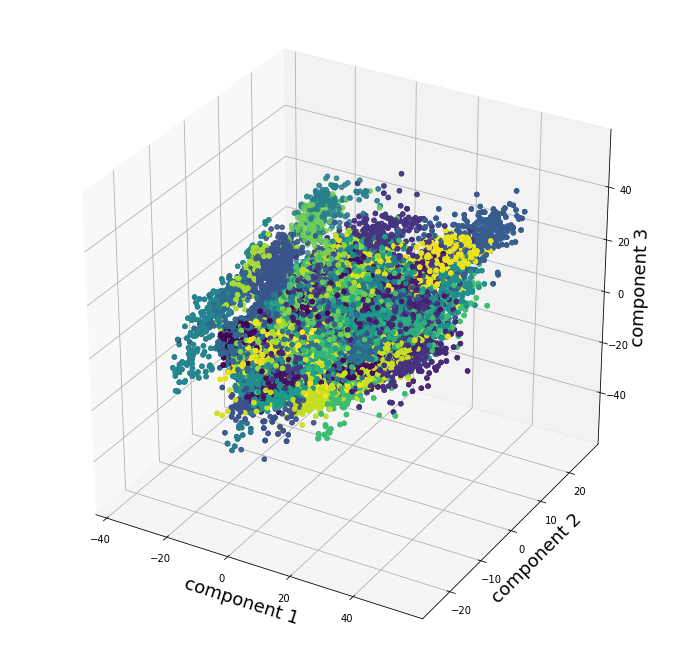

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(pca_img[:, 0], pca_img[:, 1], pca_img[:, 2], c=kmeans.labels_)

ax.set_xlabel('component 1', fontsize=18)
ax.set_ylabel('component 2', fontsize=18)
ax.set_zlabel('component 3', fontsize=18)

plt.show()

In [19]:
path = './clustered'

if not os.path.isdir(path):
    os.mkdir(path)

n = 0
for i in range(kmeans.labels_.max()):
    
    cluster_path = '{}/{}'.format(path, i)
    
    if not os.path.isdir(cluster_path):
        os.mkdir(cluster_path)
    
    tmp = images[kmeans.labels_ == kmeans.labels_[i]]
    
    for j in range(np.shape(tmp)[0]):
        tmpImg = np.reshape(tmp[j], convSize).astype(np.uint8)
        imageio.imwrite('{}/{}.jpg'.format(cluster_path, n), tmpImg)
        n += 1
        
# Delete the un-clustered data
[os.remove(data_path + x) for x in os.listdir(data_path)]
os.rmdir(data_path)

In [9]:
#Location of sorted data
dataset_path = './data/' 

# Location of converted data
dest_folder = './datasetTMP/' 

#  Tran- test data ratio
train_percent = 0.7

# Subfolders for structuring the sorted data
train_path = dataset_path + 'train/'
test_path = dataset_path + 'test/'

# Find all folders in the sorted data
folders = os.listdir(dataset_path)

# Create folders
if not os.path.isdir(train_path):
    os.mkdir(train_path)
    os.mkdir(test_path)
    
if not os.path.isdir(dest_folder):
    os.mkdir(dest_folder)
    
# Go through all folders in the sorted data and split into train and test    
for char in folders:
    char_path = dataset_path + char + '/'
    train_folder = train_path + char + '/'
    test_folder = test_path + char + '/'
    
    samples = os.listdir(char_path)
    n_samples = len(samples)
    n_train = round(train_percent * n_samples)
    
    sel = np.arange(n_samples)
    np.random.shuffle(sel)
    
    idx_train = sel[0:n_train] 
    idx_test = sel[n_train:]
    
    if not os.path.isdir(train_folder):
        os.mkdir(train_folder)
        
    if not os.path.isdir(test_folder):
        os.mkdir(test_folder)
    
    [os.rename(char_path + samples[x], train_folder + samples[x]) for x in idx_train]
    [os.rename(char_path + samples[x], test_folder + samples[x]) for x in idx_test]
    
    os.rmdir(char_path)
    
# Convert data to idx format    
Idx.save_idx(train_path)
Idx.save_idx(test_path)

# Move converted dataset to target folder
os.rename(train_path + 'images.idx3-ubyte', dest_folder + 'train-images.idx3-ubyte')
os.rename(train_path + 'labels.idx3-ubyte', dest_folder + 'train-labels.idx3-ubyte')
os.rename(test_path + 'images.idx3-ubyte', dest_folder + 'test-images.idx3-ubyte')
os.rename(test_path + 'labels.idx3-ubyte', dest_folder + 'test-labels.idx3-ubyte')

In [3]:
chars = os.listdir('./data/train')
dest_folder = './datasetTMP/' 

labelFile = open('{}/labels.txt'.format(dest_folder), "w")
for char in chars:
    
    #if char.endswith('_'):
        #char = char[:-1].upper()
    
    # write line to output file
    labelFile.write(char)
    labelFile.write("\n")
labelFile.close()